In [52]:
import collections
import copy
import csv
import subprocess
import io

import lightgbm as lgb
import imageio
from IPython.display import HTML
import math
import matplotlib.pyplot
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

import constants
import map_structure
import preprocess
import hivemind_segments_from_video

In [38]:
# Define the path to the video file and list of events with their timestamps
video_path = './game_637156.mkv'
events = [
    {'name': 'game start', 'time': 5.16},
    {'name': 'last gate tag', 'time': 160.608 + 5.16},
    {'name': 'Event 3', 'time': 135}
]

seek_js = """
<script>function seekVideo(timestamp) {
    var videoPlayer = document.getElementById('video-player');
    videoPlayer.currentTime = timestamp;
}</script>"""

# Define the HTML code for the video player and event buttons
video_player_html = f'<video id="video-player" src="{video_path}" controls width=740 height=405></video>'
event_buttons_html = ""
for event in events:
    event_buttons_html += f"""
    <button onclick="seekVideo({event['time']})">{event['name']}</button>
    """

# Combine the HTML and JavaScript code and display it
html = f"""
{seek_js}
{video_player_html}
<div>
{event_buttons_html}
</div>
"""
display(HTML(html))


In [3]:
video = imageio.get_reader(video_path, 'ffmpeg')

def is_start_screen(frame):
    texts = hivemind_segments_from_video.extract_text(frame)
    return hivemind_segments_from_video.is_kq_start_screen_ocr_text(texts)


def find_game_start_frame():
    found_start_screen = False
    step_size = 180
    for cand_frame in range(0, len(video), 180):
        img = video.get_data(cand_frame)
        if found_start_screen:
            if not is_start_screen(img):
                print('found non start screen at ', cand_frame)
                for maybe_last_start in range(cand_frame - step_size + 1, cand_frame):
                    img = video.get_data(maybe_last_start)
                    if not is_start_screen(img):
                        print('game start frame is', maybe_last_start, 'in seconds', maybe_last_start /60)
                        return maybe_last_start

        else:
            found_start_screen = is_start_screen(img)
            if found_start_screen:
                print('got first start screen at', cand_frame)
    return None
                
#start_frame = find_game_start_frame()
#print(start_frame)
start_frame = 310

In [53]:
bst = lgb.Booster(model_file='model_experiments/no_food_dep2/model.mdl')  # init model


In [5]:
def get_events_and_states_for_game(game_id):
    cmd_list = ['grep -h',  f"',{game_id}'", 
                'validated_all_gameevent_partitioned/gameevents_08[23].csv']
    raw_events_str = subprocess.getoutput(' '.join(cmd_list))
    csv_reader = csv.DictReader(
        io.StringIO(constants.GAME_EVENT_HEADER + '\n' + raw_events_str))
    
    game_event_iterator = preprocess.iterate_events_from_csv_reader(csv_reader)
    
    msi = map_structure.MapStructureInfos()
    ret = []
    iterable = preprocess.iterate_game_events_with_state(game_event_iterator, msi)
    for game_id, event, game_state, all_game_events in iterable:
        ret.append((game_id, event, copy.deepcopy(game_state), all_game_events))
    return ret    

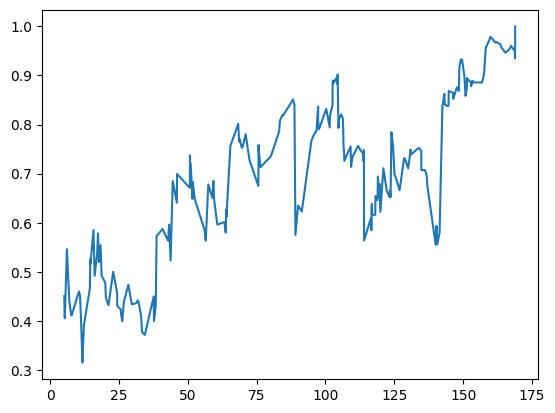

In [43]:
def plot_lwp(game_id):
    single_game_events = get_events_and_states_for_game(game_id)
    single_game_states_matrix, labels = preprocess.create_game_states_matrix(single_game_events)
    classified = bst.predict(single_game_states_matrix)
    last_timestamps = [e.timestamp for _, e, _, _ in single_game_events][-len(classified):]
    plt.plot(last_timestamps, classified)
plot_lwp(637156)

In [54]:
starting_frames_by_game_id = {}
last_kq_start_frame = None
for line in open('hivemind_frame_indexes.txt', 'r'):
    if 'capture hivemind' in line:        
        starting_frames_by_game_id[int(line.split('/')[-1])] = last_kq_start_frame
    if 'capture kq start' in line:
        last_kq_start_frame = int(line.split()[3])
print(len(starting_frames_by_game_id))                     

81


In [55]:
candidate_events_list = list(preprocess.iterate_events_from_csv(
    'validated_all_gameevent_partitioned/gameevents_08[23].csv'))
relevant_events = [e for e in candidate_events_list if e.game_id in starting_frames_by_game_id]
print('num relevant events', len(relevant_events))
print('distinct found games', len(set(e.game_id for e in relevant_events)))


num relevant events 14451
distinct found games 81


In [56]:
preprocess.debug_print_events([relevant_events[0]])

Spawn {'game_id': 637260, 'is_bot': False, 'position_id': 4, 'timestamp': datetime.datetime(2023, 2, 14, 5, 0, 32, 728000, tzinfo=tzutc())}


In [57]:
preds_by_game = collections.defaultdict(list)
labels_by_game = collections.defaultdict(list)
for game_id, event, game_state, all_game_events in preprocess.iterate_game_events_with_state(
    relevant_events, map_structure.MapStructureInfos()):
    if event.timestamp > 5:
        preds_by_game[game_id].append(bst.predict([preprocess.vectorize_game_state(game_state, event)]))
        labels_by_game[game_id].append(1 if all_game_events[-1].winning_team == preprocess.Team.BLUE else 0)
    
games_and_losses = []
ll_by_game = {}
for game_id in preds_by_game:
    these_preds = (
        np.array(preds_by_game[game_id]) if labels_by_game[game_id][0] == 1 
        else 1 - np.array(preds_by_game[game_id]))
    label_set = set(labels_by_game[game_id])
    ll_by_game[game_id] = [-math.log(p) for p in these_preds]
    my_ll = sum(ll_by_game[game_id]) / len(these_preds)

    logloss = sklearn.metrics.log_loss(labels_by_game[game_id], preds_by_game[game_id], labels=[0,1])    
    # print(f'{labels_by_game[game_id][0]}, {abs(my_ll - logloss):,.4f}, {my_ll:,.4f} {logloss:,.4f}')
    games_and_losses.append((logloss, game_id))
    
games_and_losses.sort(reverse=True)
print(games_and_losses[:10])


[(1.5178399654751629, 637171), (1.4415385896072377, 637148), (1.348297401859779, 637239), (1.1914809771092123, 637358), (1.1690941158760213, 637241), (1.081341845264749, 637113), (1.0150557219268814, 637137), (0.9311987299530332, 637181), (0.8845875644703651, 637322), (0.8776742009913455, 637309)]


https://www.youtube.com/watch?v=6Ke8qHIGd00&t=3147s


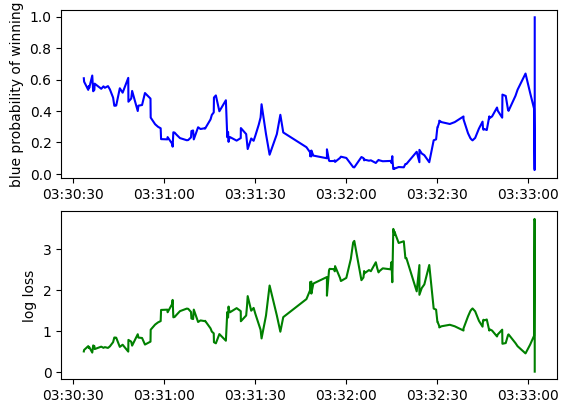

In [58]:

interesting_game_id = 637171

total_seconds = starting_frames_by_game_id[interesting_game_id] // 60
print(f'https://www.youtube.com/watch?v=6Ke8qHIGd00&t={total_seconds}s')
# print(' '.join([f'{ll:.4f}' for ll in ll_by_game[game_id]]))
num_preds = len(preds_by_game[interesting_game_id])
timestamps = [e.timestamp for e in relevant_events if e.game_id == interesting_game_id][-num_preds:]

plt.subplot(2, 1, 1)
plt.plot(timestamps, preds_by_game[interesting_game_id], 'b')
plt.ylabel('blue probability of winning')
plt.subplot(2, 1, 2)
plt.plot(timestamps, ll_by_game[interesting_game_id], 'g')
plt.ylabel('log loss')
plt.show()

In [ ]:
plot_lwp(637125)